This journal processes population data from GHSL 
1. Data ingestion and formatting
2. Exploratory data analysis
3. Data transformation - Structuring data for use with typical geospatial analysis tools
4. Exporting data as geojson file

AI Usage Disclosure: Microsoft copilot was used for templating and syntax correction. The majority of the code was written manually based on previous experience with similar work. 

In [1]:
# Import required libraries for processing raster data and converting to an appropriate format for use with other libraries
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import transform
import matplotlib.pyplot as plt
import numpy as np   

In [2]:
# Get the raster file from the sourceData folder using rasterio
raster_path = 'sourceData/GHS_BUILT_S_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C11.tif'
# Open the file and read the CRS
raster = rasterio.open(raster_path)
print("Raster CRS:", raster.crs)
print("Raster bounds:", raster.bounds)
print("Raster resolution:", raster.res)
print("Raster width, height:", raster.width, raster.height)
print("Total number of pixels:", raster.width * raster.height)

Raster CRS: ESRI:54009
Raster bounds: BoundingBox(left=-8041000.0, bottom=4000000.0, right=-7041000.0, top=5000000.0)
Raster resolution: (100.0, 100.0)
Raster width, height: 10000 10000
Total number of pixels: 100000000


Min: 0
Max: 10000
Mean: 134.66204115
Median: 0.0
Std: 506.3116594094844
Valid pixels: 100000000


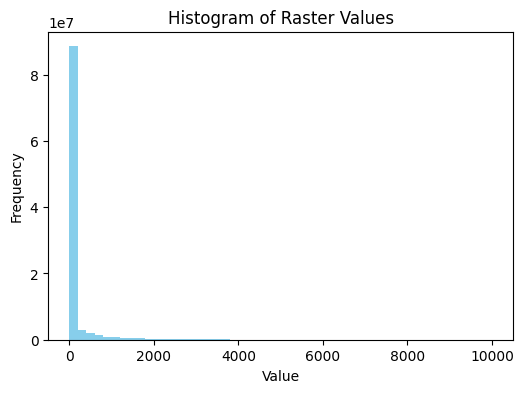

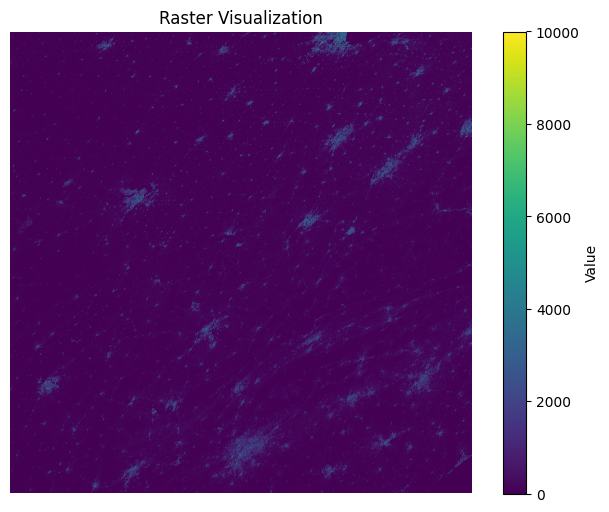

In [3]:
# Raster EDA: Summary statistics, histogram, and visualization

# Read the first band as a numpy array
band1 = raster.read(1)

# Mask no-data values
band1 = np.ma.masked_equal(band1, raster.nodata)

# Summary statistics
print('Min:', band1.min())
print('Max:', band1.max())
print('Mean:', band1.mean())
print('Median:', np.ma.median(band1))
print('Std:', band1.std())
print('Valid pixels:', np.ma.count(band1))

# Histogram
plt.figure(figsize=(6,4))
plt.hist(band1.compressed(), bins=50, color='skyblue')
plt.title('Histogram of Raster Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Visualization
plt.figure(figsize=(8,6))
plt.imshow(band1, cmap='viridis')
plt.title('Raster Visualization')
plt.colorbar(label='Value')
plt.axis('off')
plt.show()

In [4]:
# The visualization looks as you would expect with regard to urban areas in the area
# Also as expected, many areas have a value of 0. Let's build a CSV file that trims out these 0 values
# and includes the lat/lon coordinates for each pixel

# First, get the indices of non-zero, valid pixels
rows, cols = np.where((band1 > 0) & (~band1.mask))
latitudes = raster.xy(rows, cols)[0]
longitudes = raster.xy(rows, cols)[1]
values = band1[rows, cols]

# Get population values for the selected pixels
popValues = band1[rows, cols]

# Convert row/col indices to coordinates
xs, ys = rasterio.transform.xy(raster.transform, rows, cols)
lons = np.array(xs)
lats = np.array(ys)

# Convert coordinates from raster CRS to WGS84 (lat/lon), using rasterio.warp.transform
lons, lats = transform(
    raster.crs,  # source CRS
    'EPSG:4326',  # target CRS
    xs,  # x coordinates (e.g., from rasterio.transform.xy)
    ys   # y coordinates
)

print("Sample coordinates and values:")
for i in range(5):
    print(f"Longitude: {lons[i]}, Latitude: {lats[i]}, Population: {popValues[i]}")


Sample coordinates and values:
Longitude: -96.09118553682552, Latitude: 41.893700003085165, Population: 25
Longitude: -96.08998672719252, Latitude: 41.893700003085165, Population: 249
Longitude: -95.85621884876021, Latitude: 41.893700003085165, Population: 566
Longitude: -95.85502003912724, Latitude: 41.893700003085165, Population: 34
Longitude: -95.78429027078104, Latitude: 41.893700003085165, Population: 258


In [5]:
# We can now assemble a dataframe
data = {
    'latitude': lats,
    'longitude': lons,
    'population': popValues
}
df = pd.DataFrame(data)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19541153 entries, 0 to 19541152
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   latitude    float64
 1   longitude   float64
 2   population  uint16 
dtypes: float64(2), uint16(1)
memory usage: 335.4 MB
None
   latitude  longitude  population
0   41.8937 -96.091186          25
1   41.8937 -96.089987         249
2   41.8937 -95.856219         566
3   41.8937 -95.855020          34
4   41.8937 -95.784290         258


In [6]:
# As with the pollution data, we want to trim this down to the area around Peachtree Corners, GA
# We will use slightly expanded lat/lon bounds to ensure we capture the full area of interest
minLat, maxLat = 33.900271 - 0.1, 34.051360 + 0.1
minLon, maxLon = -84.290703 - 0.1, -84.142546 + 0.1

trimmedDF = df[(df['latitude'] >= minLat) & (df['latitude'] <= maxLat) & (df['longitude'] >= minLon) & (df['longitude'] <= maxLon)]

# Normalize population scales to range from 0 to 1
trimmedDF['population_normalized'] = (trimmedDF['population'] - trimmedDF['population'].min()) / (trimmedDF['population'].max() - trimmedDF['population'].min())
print(trimmedDF.info())
print(trimmedDF.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 117406 entries, 16806990 to 17890602
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               117406 non-null  float64
 1   longitude              117406 non-null  float64
 2   population             117406 non-null  uint16 
 3   population_normalized  117406 non-null  float64
dtypes: float64(3), uint16(1)
memory usage: 3.8 MB
None
            latitude      longitude     population  population_normalized
count  117406.000000  117406.000000  117406.000000          117406.000000
mean       33.973283     -84.217119    1508.839940               0.150799
std         0.100384       0.099918    1217.665936               0.121779
min        33.800442     -84.390703       1.000000               0.000000
25%        33.886362     -84.302873     557.000000               0.055606
50%        33.971447     -84.218252    1288.000000               0.1

C:\Users\danes\AppData\Local\Temp\ipykernel_26944\3145197584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmedDF['population_normalized'] = (trimmedDF['population'] - trimmedDF['population'].min()) / (trimmedDF['population'].max() - trimmedDF['population'].min())


In [7]:
# Export as CSV for later use
trimmedDF.to_csv('processedData/populationData_PeachtreeCorners.csv', index=False)